If I don't prevent OpenMP threading, I end up with a *ton* of system time from multithreaded BLAS that actually lowers performance:

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [18]:
import arviz as az
from emcee import EnsembleSampler
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx
import scipy.linalg as sl
import scipy.stats as ss
import starry
from starry import Map, System, Primary, Secondary
import starry_process
from starry_process import StarryProcess
import theano
import theano.tensor as tt
from theano.tensor.random.utils import RandomStream
from tqdm.notebook import tqdm

Formulas:
$$
N\left( f \mid M y, C \right) N\left( y \mid \mu, \Lambda \right) = N\left( y \mid a, A \right) N\left( f \mid b, B \right)
$$
where
$$
A^{-1} = \Lambda^{-1} + M^T C^{-1} M
$$
$$
a = A \left( \Lambda^{-1} \mu + M^T C^{-1} M f \right)
$$
$$
b = M \mu
$$
$$
B = C + M \Lambda M^T
$$

Useful re-writing:
$$
A = \left( I + \Lambda M^T C^{-1} M \right)^{-1} \Lambda
$$

$$
B^{-1} = C^{-1} - C^{-1} M \left( I + \Lambda M^T C^{-1} M \right)^{-1} \Lambda M^T C^{-1}
$$

In [42]:
def _cho_solve(L, b):
    return tt.slinalg.solve_upper_triangular(L.T, tt.slinalg.solve_lower_triangular(L, b))

class LinearInterpolatedStarryStarryProcess(object):
    def __init__(self, sys, sp, nt, nlm):
        self._sys = sys
        self._sp = sp
        self._nt = nt
        self._nlm = nlm

        self._mu = tt.concatenate((sp.mean_ylm, sp.mean_ylm))
        C = sp.cov_ylm
        self._Lambda = tt.zeros((2*nlm, 2*nlm))
        self._Lambda = tt.set_subtensor(self._Lambda[:nlm,:nlm], C)
        self._Lambda = tt.set_subtensor(self._Lambda[nlm:, nlm:], C)

    @property
    def nt(self):
        return self._nt
    @property
    def nlm(self):
        return self._nlm

    @property
    def sys(self):
        return self._sys
    @property
    def sp(self):
        return self._sp
    
    @property
    def mu(self):
        return self._mu
    @property
    def Lambda(self):
        return self._Lambda
    
    @property
    def primary(self):
        return self.sys.primary
    @property
    def secondary(self):
        return self.sys.secondaries[0]
    
    @property
    def design_matrix(self):
        return self._M

    @property
    def logl_marginal(self):
        return self._logl_marginal
    @property
    def a(self):
        return self._a
    @property
    def AInv_chol(self):
        return self._AInv_chol

    def _compute(self, t, flux, sigma_flux):
        MM = self.sys.design_matrix(t)[:,:-1] # We don't use any flux from the secondary, so [:, :-1]

        T0 = t[0]
        T1 = t[-1]

        phi0 = (t - T1)/(T0 - T1)
        phi1 = (t - T0)/(T1 - T0)

        M0 = phi0[:, None] * MM
        M1 = phi1[:, None] * MM

        M = tt.concatenate([M0, M1], axis=1)

        self._M = M

        nlm = self.nlm
        nt = self.nt

        mu = self.mu
        Lambda = self.Lambda

        # We want to enforce that the prior on the constant term in the map is
        # completely flat, so we set the first row and column of the precision
        # matrix to zero we do this manually here.  First we Cholesky decompose:
        #
        # Lambda[1:,1:] = L L^T
        #
        # Then, because of a quirk of theano (no gradients for `cho_solve!`,
        # WTF), we can compute Lambda[1:,1:]^{-1} via
        #
        # Lambda[1:,1:]^{-1} = tt.slinalg.solve_triangular(L.T, tt.slinalg.solve_triangular(L, tt.eye(nlm-1), lower=True), lower=False)
        #
        # encapsulated in our _cho_solve(...) function above

        # Also: the covariance matrix contains a "double-copy" of the starry
        # process covariance: CC = [[C, 0], [0, C]], and we only have to solve
        # one of them, and then can reconstruct the inverse as 
        # CC^{-1} = [[C^{-1}, 0], [0, C^{-1}]].
        L = tt.slinalg.cholesky(Lambda[1:nlm,1:nlm])
        Lambda_inv = _cho_solve(L, tt.eye(nlm-1))
        Lambda_inv = tt.set_subtensor(tt.zeros((nlm, nlm))[1:,1:], Lambda_inv)

        Lambda_inv = tt.set_subtensor(tt.zeros((2*nlm, 2*nlm))[:nlm,:nlm], Lambda_inv)
        Lambda_inv = tt.set_subtensor(Lambda_inv[nlm:,nlm:], Lambda_inv[:nlm,:nlm])

        sigma_flux2 = tt.square(sigma_flux)
        MTCinv = M.T / sigma_flux2[None, :]
        MTCinvM = tt.dot(MTCinv, M)

        AInv = Lambda_inv + MTCinvM
        AInv_chol = tt.slinalg.cholesky(AInv)
        a = _cho_solve(AInv_chol, tt.dot(Lambda_inv, mu) + tt.dot(MTCinv, flux))

        self._a = a
        self._AInv_chol = AInv_chol

        b = tt.dot(M, mu)
        r = flux - b

        Cinvr = r / sigma_flux2

        rtilde = Cinvr - tt.dot(MTCinv.T, tt.slinalg.solve(AInv, tt.dot(MTCinv, r)))

        # Identity:
        # |B| = |I + M^T C^-1 M L| |C| = |L^-1 + M^T C^-1 M| |L| |C|
        # But we want to cancel the infinite constant in L[0,0], so we ignore the first row and column of L:
        # |B| = | A^-1 | |L[1:,1:]| |C|
        # The "4" below comes because we have *two* copies of the covariance matrix for starry process in the full covariance matrix.

        logdetB = tt.sum(tt.log(sigma_flux2)) + 2*tt.sum(tt.log(tt.diag(AInv_chol))) + 4*tt.sum(tt.log(tt.diag(L)))

        # (nt-2) because we have cancelled two dimensions due to the flat prior
        # on the [0,0] constant term in each of the interpolant maps.
        logl = -0.5*tt.dot(r, rtilde) - 0.5*logdetB - 0.5*(nt-2)*tt.log(2*np.pi)
        self._logl_marginal = logl

    def marginal_likelihood(self, t, flux, sigma_flux):
        self._compute(t, flux, sigma_flux)
        return self.logl_marginal
    
    def sample_ylm_conditional(self, t, flux, sigma_flux, size=1, rng=None):
        if rng is None:
            rng = RandomStream(seed=np.random.randint(1<<32))

        nylm = self.nlm

        self._compute(t, flux, sigma_flux)
        return self.a[None,:] + tt.slinalg.solve_upper_triangular(self.AInv_chol.T, rng.normal(size=(2*nylm, size))).T

In [43]:
starry.config.lazy = True

ydeg = 15
udeg = 2

u1 = 0.4
u2 = 0.26

r = 20.0
dr = 5.0
n = 1
c = 0.5
mu = 30.0
sigma = 5.0

prot = 30.0
porb = 4.887802443

stellar_inc = 90.0
stellar_obl = -30.0

rng = np.random.default_rng(302592346730275158208684369480422136411)

pri = Primary(starry.Map(ydeg, udeg=udeg, inc=stellar_inc, obl=stellar_obl),
              r=0.683, m=0.81, prot=prot, t0=0.0)
sec = Secondary(starry.Map(0, 0), 
                t0=0, r=0.04*pri.r.eval(), m=1e-3*pri.m.eval(), prot=1.0,
                porb=porb, ecc=0.0, Omega=0, inc=90)
pri.map[1] = u1
pri.map[2] = u2

sys = System(pri, sec)

Ttr_half = 0.1
dt_in_transit = Ttr_half / 20.0
dt_out_transit = prot / 20.0

sp = StarryProcess(n=n, mu=mu, sigma=sigma, r=r, dr=dr, ydeg=ydeg, udeg=udeg, marginalize_over_inclination=False, seed=rng.integers(0, 1<<32))

y0_true = sp.sample_ylm().eval()[0,:]
y1_true = sp.sample_ylm().eval()[0,:]
y0_true[0] = 1.0
y1_true[0] = 1.02

T = 3*prot
t_in = np.arange(-T, T, dt_in_transit)
t_out = np.arange(-T, T, dt_out_transit)

t_in_transit = (t_in % sec.porb.eval() < Ttr_half) | (t_in % sec.porb.eval() > sec.porb.eval()-Ttr_half)
t_out_transit = (t_out % sec.porb.eval() < Ttr_half) | (t_out % sec.porb.eval() > sec.porb.eval()-Ttr_half)

t = np.sort(np.concatenate((
    t_in[t_in_transit],
    t_out[~t_out_transit],
)))
nt = len(t)

ssp = LinearInterpolatedStarryStarryProcess(sys, sp, nt, len(pri.map.y.eval()))
ssp._compute(t, np.zeros_like(t), np.ones_like(t))

flux_true = ssp.design_matrix.eval() @ np.concatenate((y0_true, y1_true))
sigma_flux = 1e-4*np.ones_like(flux_true)

flux_obs = flux_true + sigma_flux*rng.normal(size=nt)

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.


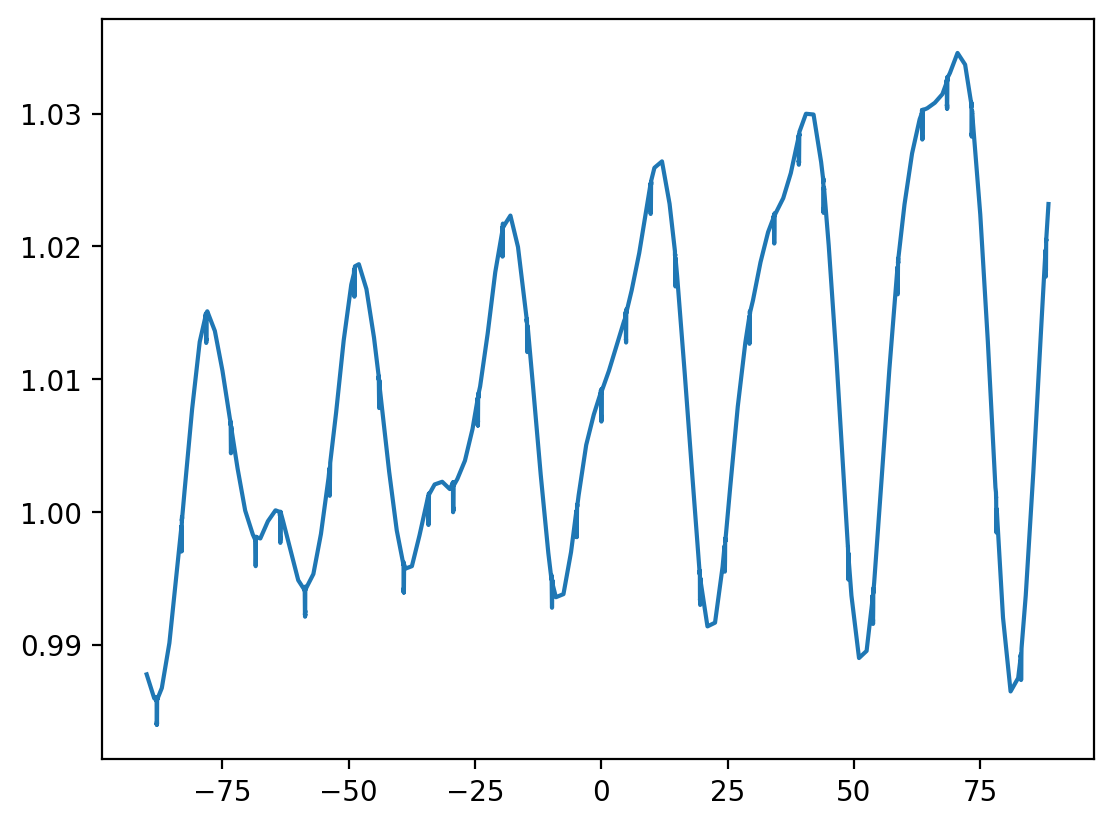

In [44]:
plt.plot(t, flux_obs)

In [45]:
len(t)

1597

/Users/wfarr/miniconda3/envs/StarryStarryProcess/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


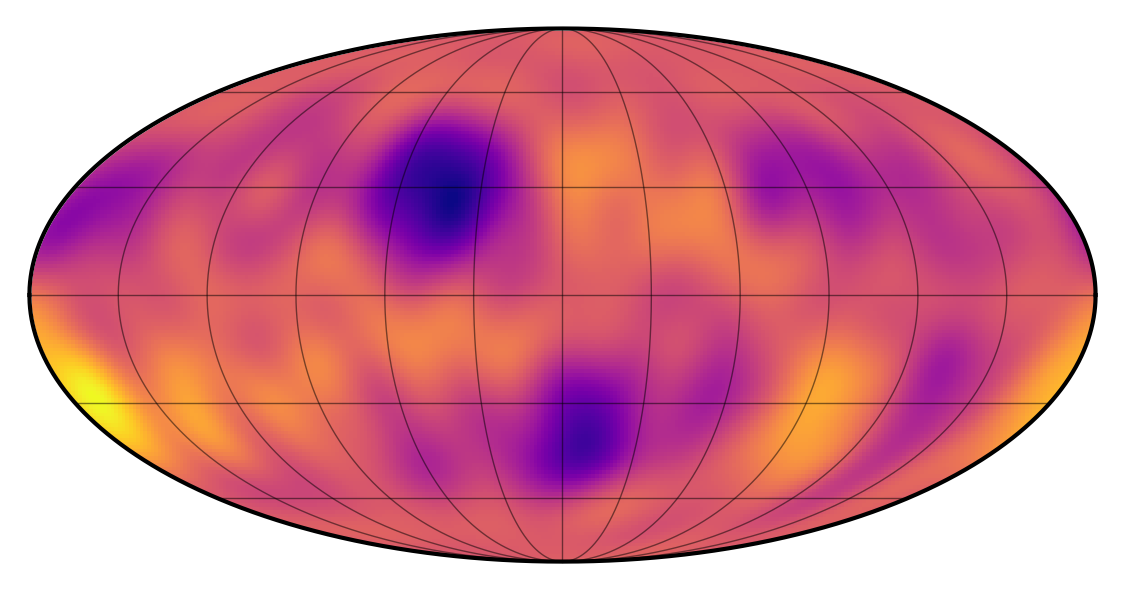

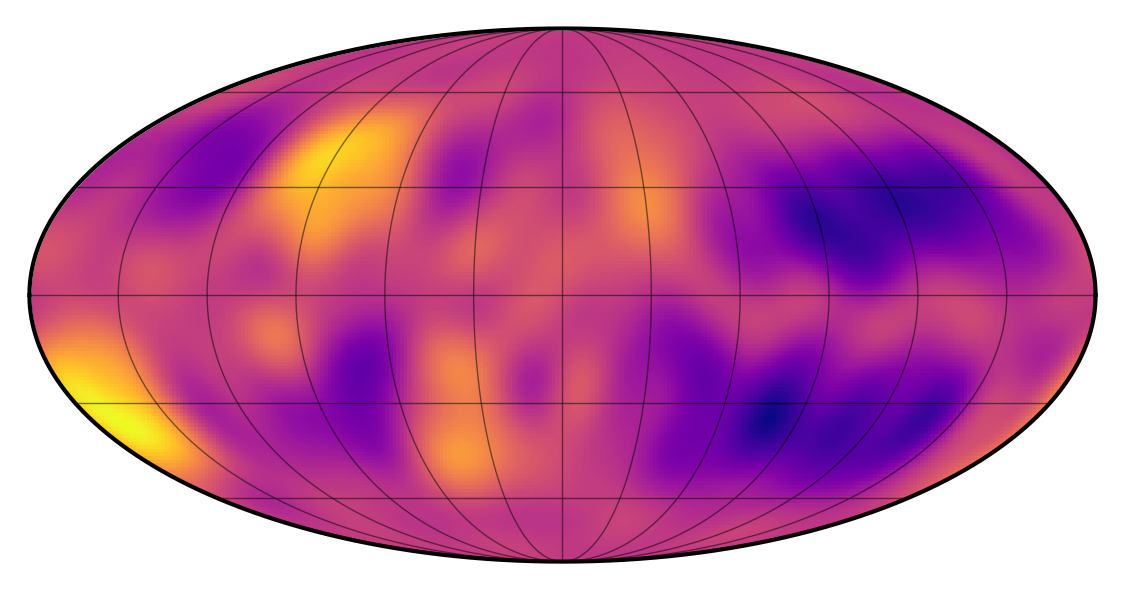

In [46]:
sp.visualize(y0_true)
sp.visualize(y1_true)

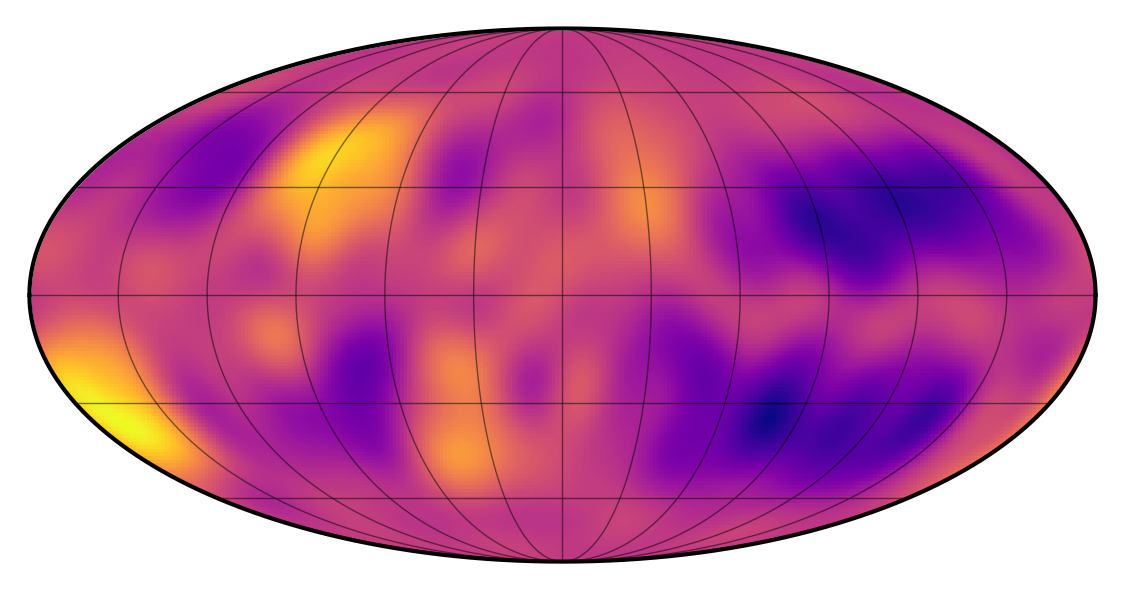

/Users/wfarr/miniconda3/envs/StarryStarryProcess/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


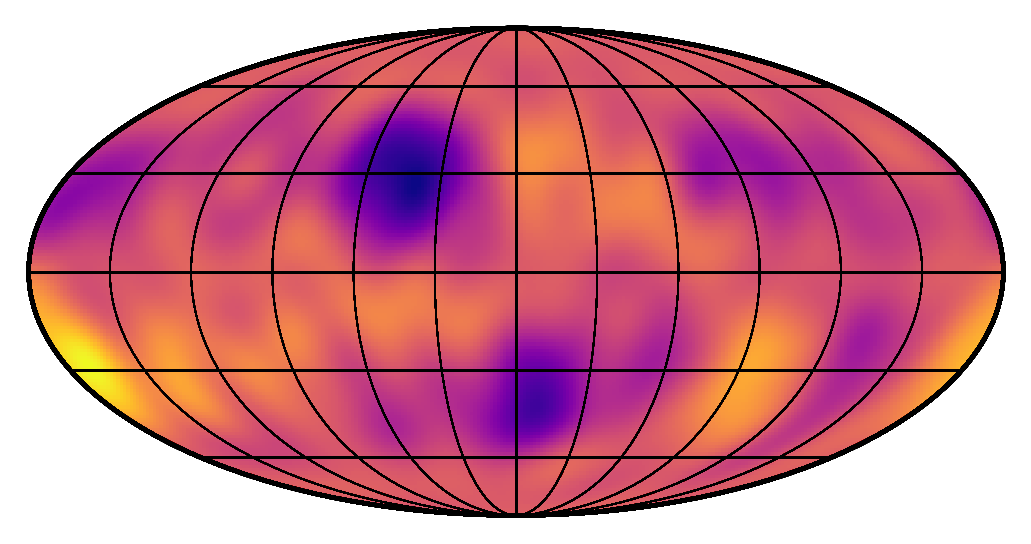

In [38]:
t_interp = np.linspace(t[0], t[-1], 100)
sp.visualize(y)
fig = plt.gcf()
ax = plt.gca()
def frame(i):
    ti = t_interp[i]
    t0 = t[0]
    t1 = t[-1]
    y = (ti - t1)/(t0-t1)*y0_true + (ti - t0)/(t1-t0)*y1_true
    sp.visualize(y, ax=ax)
    return fig
ani = FuncAnimation(fig, frame, frames=len(t_interp), interval=100)
ani.save("/Users/wfarr/Downloads/ssp.mp4")

<ErrorbarContainer object of 3 artists>

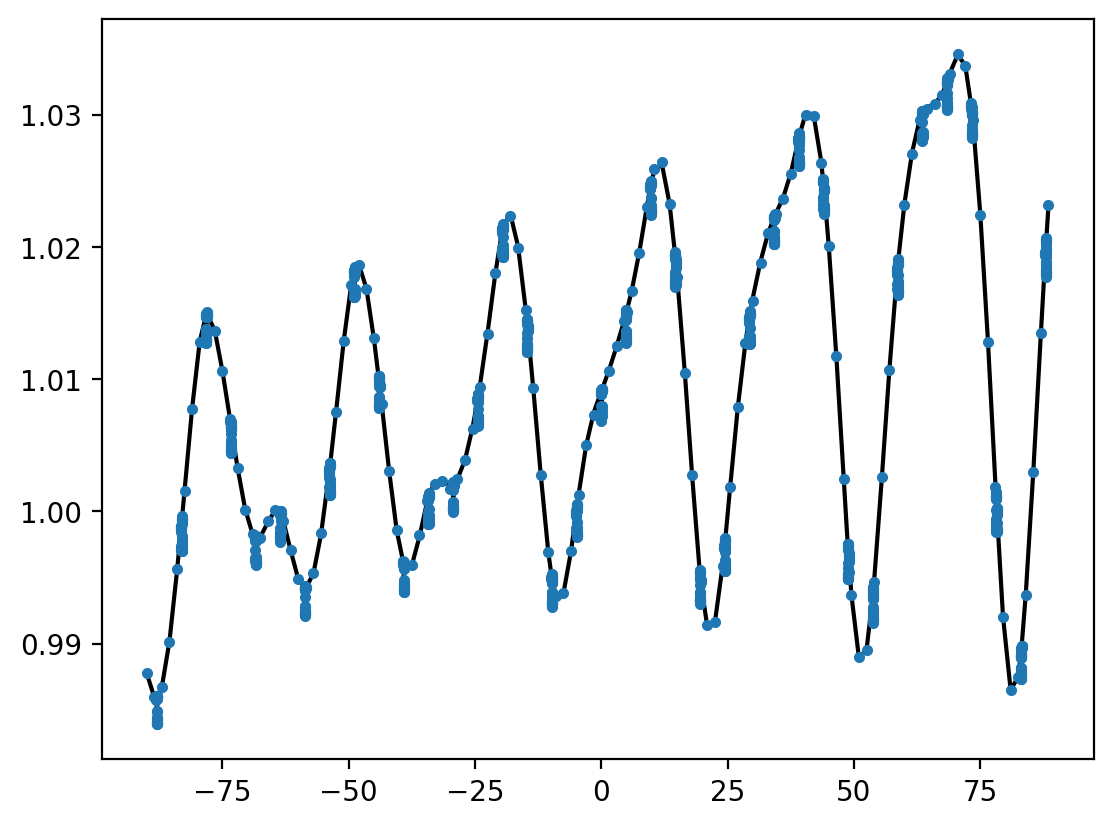

In [39]:
plt.plot(t, flux_true, color='k')
plt.errorbar(t, flux_obs, yerr=sigma_flux, fmt='.')

<ErrorbarContainer object of 3 artists>

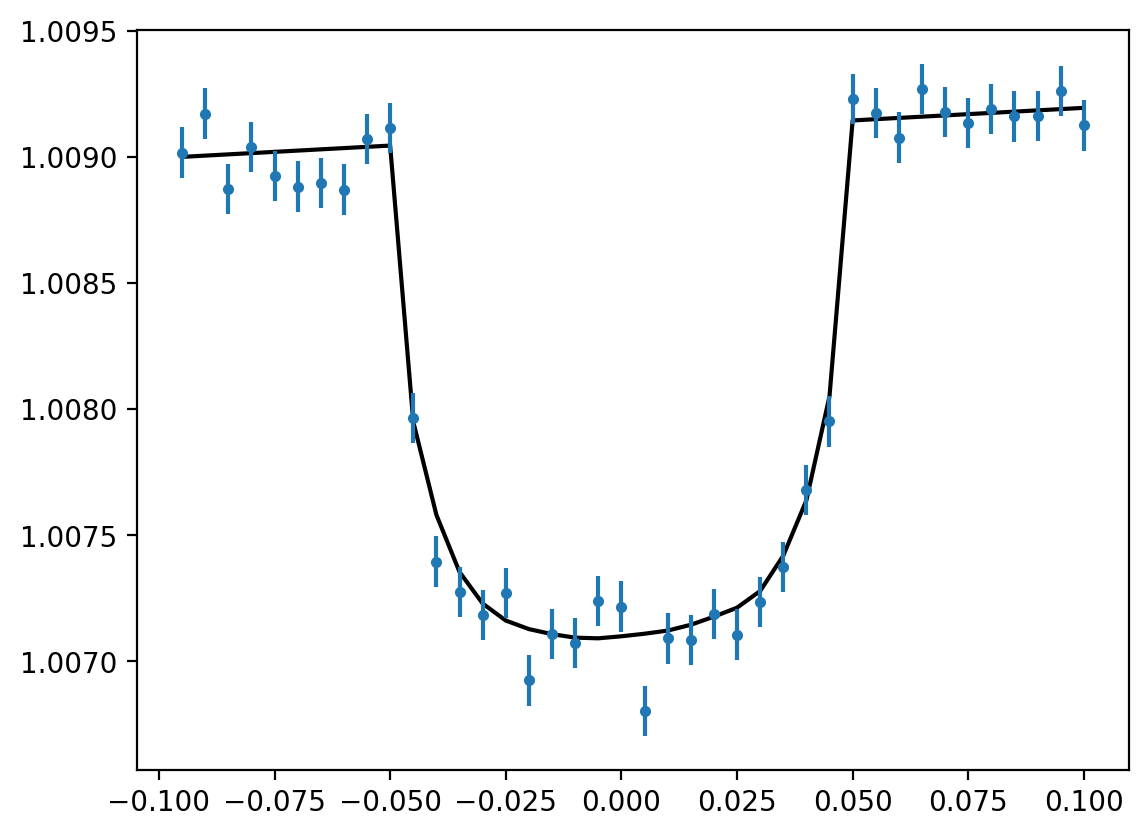

In [47]:
sel = np.abs(t) < sec.porb.eval()/10
plt.plot(t[sel], flux_true[sel], color='k')
plt.errorbar(t[sel], flux_obs[sel], yerr=sigma_flux[sel], fmt='.')

In [48]:
ylm_draw = ssp.sample_ylm_conditional(t, flux_obs, sigma_flux).eval()[0,:]

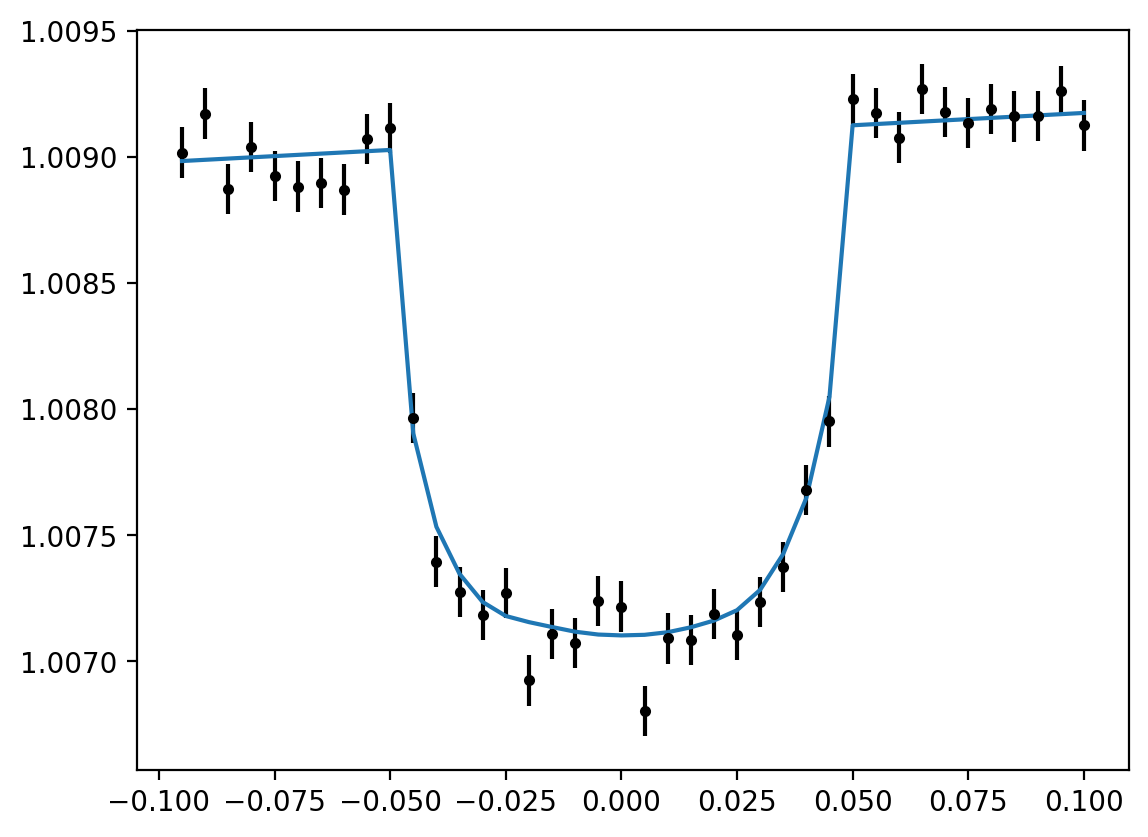

In [49]:
plt.errorbar(t[sel], flux_obs[sel], yerr=sigma_flux[sel], fmt='.', color='k')
plt.plot(t[sel], (ssp.design_matrix.eval() @ ssp.a.eval())[sel])

/Users/wfarr/miniconda3/envs/StarryStarryProcess/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


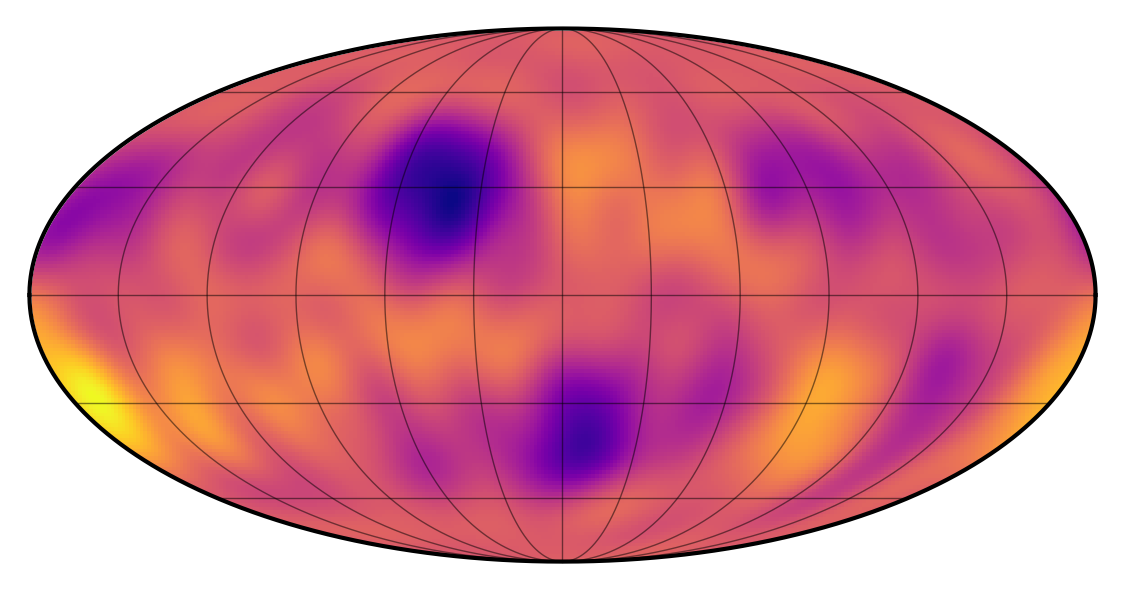

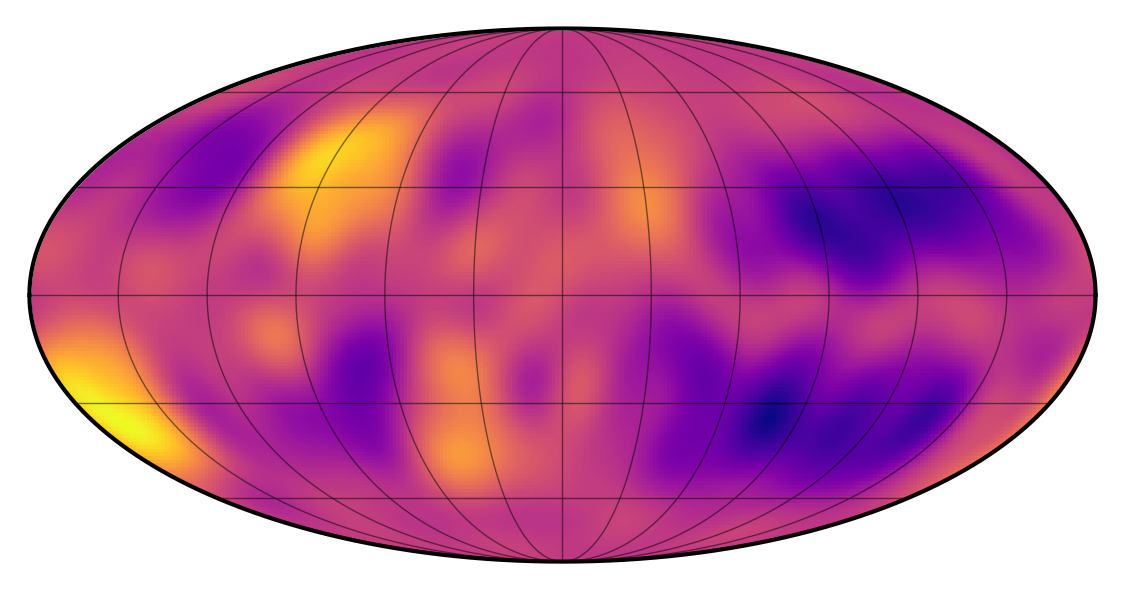

In [50]:
sp.visualize(y0_true)
sp.visualize(y1_true)

/Users/wfarr/miniconda3/envs/StarryStarryProcess/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


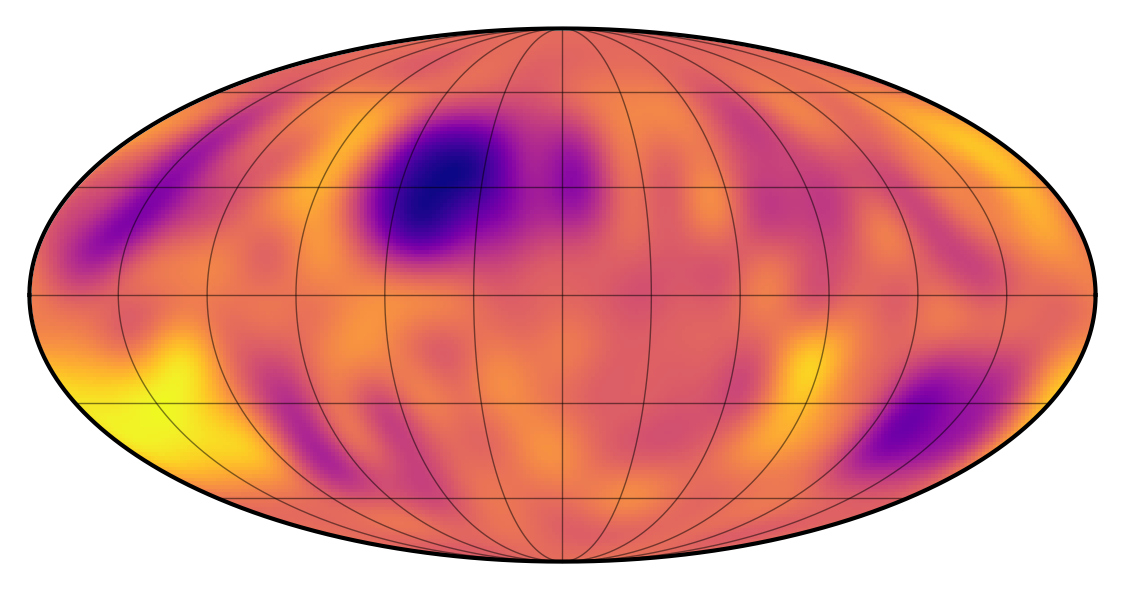

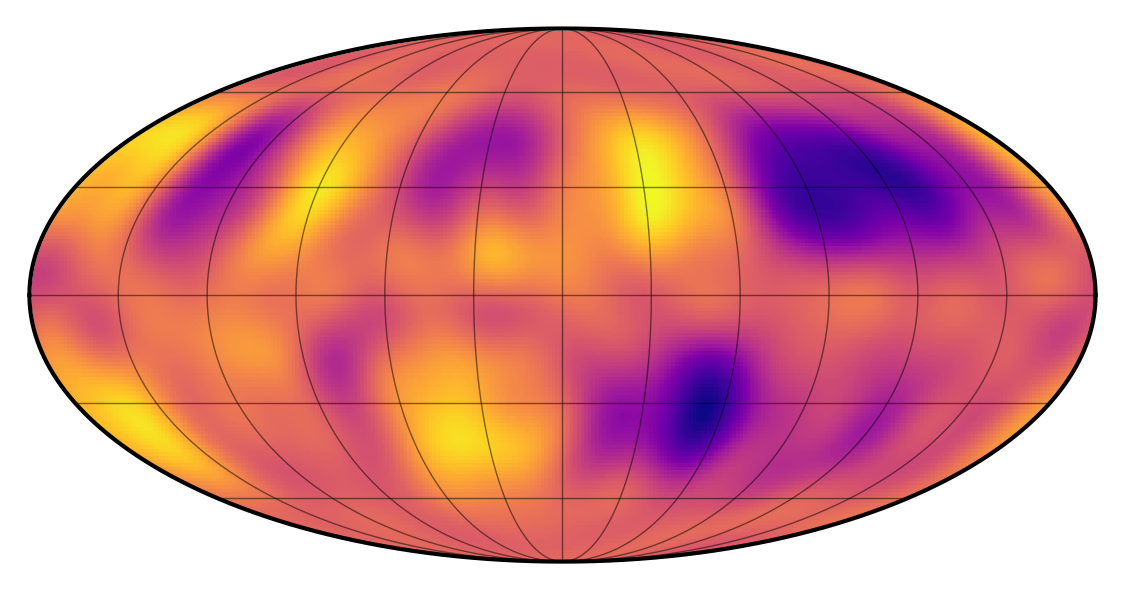

In [51]:
sp.visualize(ylm_draw[:ssp.nlm])
sp.visualize(ylm_draw[ssp.nlm:])

/Users/wfarr/miniconda3/envs/StarryStarryProcess/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


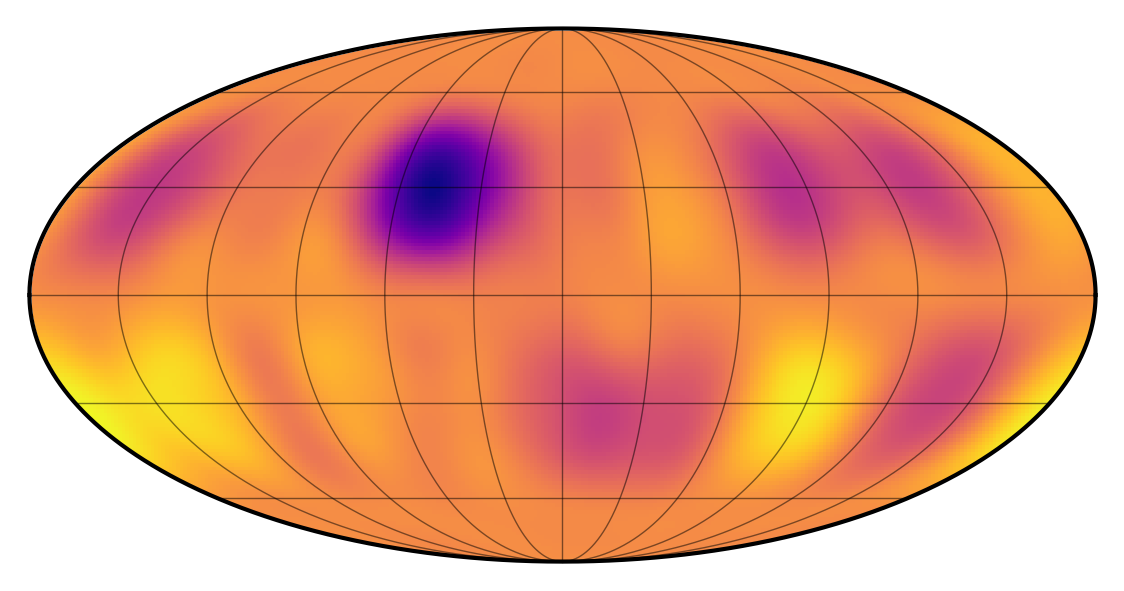

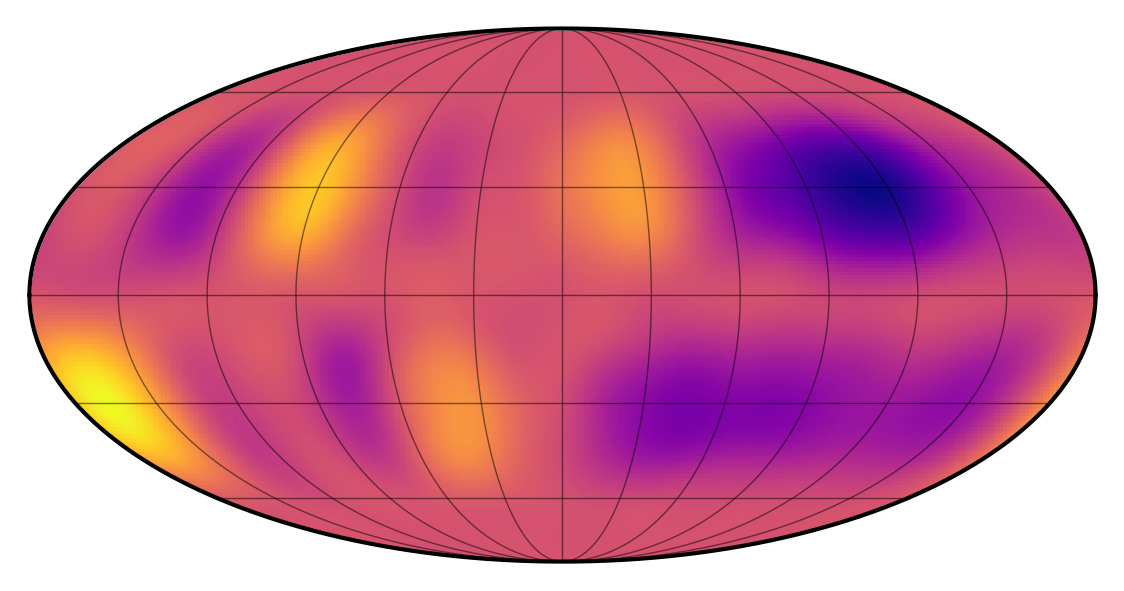

In [52]:
sp.visualize(ssp.a.eval()[:ssp.nlm])
sp.visualize(ssp.a.eval()[ssp.nlm:])

## Everything above here works, below here there are various problems with sizes.

Let's double-check the Gaussian factorization; the next two cells should give identical log-likelihoods:

In [53]:
resid = flux_obs - ssp.design_matrix.eval() @ ylm_draw
np.sum(ss.norm(loc=0, scale=sigma_flux).logpdf(resid)) - 0.5*np.dot(ylm_draw[1:] - sp.mean_ylm.eval()[1:], np.linalg.solve(sp.cov_ylm.eval()[1:,1:], ylm_draw[1:] - sp.mean_ylm.eval()[1:])) - 0.5*np.linalg.slogdet(sp.cov_ylm.eval()[1:,1:])[1] - 0.5*(len(ylm_draw)-1)*np.log(2*np.pi)

ValueError: operands could not be broadcast together with shapes (511,) (255,) 

In [33]:
whitened_ylm_resid = np.dot(ssp.AInv_chol.T.eval(), ylm_draw - ssp.a.eval())
ssp.marginal_likelihood(t, flux_obs, sigma_flux).eval() - 0.5*np.dot(whitened_ylm_resid, whitened_ylm_resid) + np.sum(np.log(np.diag(ssp.AInv_chol.eval()))) - 0.5*len(ylm_draw)*np.log(2*np.pi)

13976.943693717552

The marginal likelihood is:

In [34]:
ssp.marginal_likelihood(t, flux_obs, sigma_flux).eval()

array(12383.80950571)

Let's try some fitting

In [36]:
Ttotal = t[-1] - t[0]
prot_frac_bounds = min(prot/Ttotal/2, 0.25)
porb_frac_bounds = min(porb/Ttotal/2, 0.25)

t0_bounds = 0.2 # Hard coded!

a = (pri.m.eval()*np.square(sec.porb.eval()/365.25))**(1/3) * 215.03 # Solar radii
bmax = pri.r.eval() / a

with pm.Model() as model:
    log_prot = pm.Uniform('log_prot', np.log(prot) + np.log1p(-prot_frac_bounds), np.log(prot) + np.log1p(prot_frac_bounds))
    prot = pm.Deterministic('prot', tt.exp(log_prot))

    log_porb = pm.Uniform('log_porb', np.log(porb) + np.log1p(-porb_frac_bounds), np.log(porb) + np.log1p(porb_frac_bounds))
    porb = pm.Deterministic('porb', tt.exp(log_porb))

    t0 = pm.Uniform('t0', -t0_bounds, t0_bounds)

    log_rp = pm.Uniform('log_rp', np.log(sec.r.eval()/2), np.log(2*sec.r.eval()))
    rp = pm.Deterministic('rp', tt.exp(log_rp))

    # For some reason, the model errors out if I try to use Omega as a variable
    # on the planetary transit, but it's happy to have a stellar obliquity.
    # Since only the *relative* angle between transit and star is observable
    # anyway, this is the only relevant degree of freedom.  (Visualize: rotate
    # the star-planet system in the sky until the planet's orbit is "horizontal"
    # (zero obliquity).  The lightcurve is still the same.)  So the preferred
    # value of the stellar obliquity will be -Omega from above, and we pass
    # Omega = 0 to the planet below.
    stellar_ori_x = pm.Normal('stellar_ori_x', mu=0, sigma=1, testval=1)
    stellar_ori_y = pm.Normal('stellar_ori_y', mu=0, sigma=1, testval=1)
    stellar_ori_z = pm.Normal('stellar_ori_z', mu=0, sigma=1, testval=1)
    stellar_obl = pm.Deterministic('stellar_obl', 180.0/np.pi*tt.arctan2(stellar_ori_y, stellar_ori_x))
    stellar_inc = pm.Deterministic('stellar_inc', 180.0/np.pi*tt.arccos(stellar_ori_z / tt.sqrt(tt.square(stellar_ori_x) + tt.square(stellar_ori_y) + tt.square(stellar_ori_z))))

    # Impact parameter
    b = pm.Uniform('b', -bmax, bmax)
    planet_inc = pm.Deterministic('planet_inc', 180.0/np.pi*np.arccos(b))

    pri_model = Primary(starry.Map(ydeg=ydeg, udeg=udeg, inc=stellar_inc, obl=stellar_obl), r=float(pri.r.eval()), m=float(pri.m.eval()), prot=prot, t0=0.0)
    pri_model.map[1] = u1
    pri_model.map[2] = u2

    sec_model = Secondary(starry.Map(0,0), 
                          t0=t0, r=rp, m=float(sec.m.eval()), prot=float(sec.prot.eval()),
                          porb=porb, ecc=float(sec.ecc), Omega=0, inc=planet_inc)
    
    sys_model = System(pri_model, sec_model)

    sp_model = StarryProcess(n=n, 
                             mu=tt.as_tensor_variable(mu, 'mu'),
                             sigma=tt.as_tensor_variable(sigma, 'sigma'),
                             r=tt.as_tensor_variable(r, 'r'),
                             dr=tt.as_tensor_variable(dr, 'dr'),
                             ydeg=ydeg, udeg=udeg, 
                             marginalize_over_inclination=False,)

    # Normally we would make another StarryProcess here, but because none of its parameters are being set in the model for now, we can just reuse `sp`
    ssp_model = StarryStarryProcess(sys_model, sp_model, nt, len(pri.map.y.eval()))

    pm.Potential('marginal_likelihood', ssp_model.marginal_likelihood(t, flux_obs, sigma_flux))

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.


Note: the below will error-out due to a singularity in the `_x`, `_y`, `_z` variables at the origin.  The reason is: the MAP values of those are all zero, approaching the origin with an angle that is the MAP value of `obl` and `inc`.  But this generates a `0/0` loss of precision.  This isn't a problem for *sampling* because the origin occupies a set of zero volume---so ("almost surely all of") the samples live far from the origin clustered around the correct angle.

In [37]:
with model:
    map_soln = pmx.optimize(maxeval=500)

optimizing logp for variables: [b, stellar_ori_z, stellar_ori_y, stellar_ori_x, log_rp, t0, log_porb, log_prot]


message: Desired error not necessarily achieved due to precision loss.
logp: 4639.380566799244 -> 12375.775530471765


In [38]:
map_soln

{'log_prot_interval__': array(0.0842869),
 'log_porb_interval__': array(0.01373971),
 't0_interval__': array(-9.2901619e-05),
 'log_rp_interval__': array(0.00244181),
 'stellar_ori_x': array(0.03764404),
 'stellar_ori_y': array(0.02328141),
 'stellar_ori_z': array(-0.00080092),
 'b_interval__': array(0.07020592),
 'log_prot': array(3.40120177),
 'prot': array(30.00013164),
 'log_porb': array(1.58674313),
 'porb': array(4.88780404),
 't0': array(-9.29016189e-06),
 'log_rp': array(-3.59928998),
 'rp': array(0.02734313),
 'stellar_obl': array(31.73521773),
 'stellar_inc': array(91.03666193),
 'b': array(0.00212117),
 'planet_inc': array(89.87846555)}

In [39]:
start = dict(t0=0.0, stellar_ori_x=np.cos(-30*np.pi/180), stellar_ori_y=np.sin(-30*np.pi/180), stellar_ori_z=0.0, b=0.0, log_prot=np.log(30.0), log_porb=np.log(sec.porb.eval()), log_rp=np.log(sec.r.eval()))
ndraw = 1000
with model:
    trace = pm.sample(ndraw, tune=ndraw, chains=1, init='adapt_full', start=start, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/wfarr/miniconda3/envs/StarryStarryProcess/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:514: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Sequential sampling (1 chains in 1 job)
NUTS: [b, stellar_ori_z, stellar_ori_y, stellar_ori_x, log_rp, t0, log_porb, log_prot]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 3443 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [40]:
az.summary(trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
stellar_ori_x   1.289  0.571   0.285    2.275      0.040    0.029     178.0   
stellar_ori_y  -0.781  0.357  -1.455   -0.243      0.025    0.018     182.0   
stellar_ori_z   0.052  0.061  -0.050    0.183      0.002    0.002     652.0   
log_prot        3.401  0.000   3.401    3.401      0.000    0.000     447.0   
prot           30.000  0.001  29.998   30.003      0.000    0.000     447.0   
log_porb        1.587  0.000   1.587    1.587      0.000    0.000     480.0   
porb            4.888  0.000   4.888    4.888      0.000    0.000     480.0   
t0             -0.000  0.000  -0.000    0.000      0.000    0.000     690.0   
log_rp         -3.599  0.002  -3.603   -3.596      0.000    0.000     592.0   
rp              0.027  0.000   0.027    0.027      0.000    0.000     592.0   
stellar_obl   -31.209  3.729 -38.122  -24.101      0.142    0.100     694.0   
stellar_inc    87.978  1.983  84.654   91.856      0.074    0.052     724.0   
b              -0.000  0.002  -0.004    0.004      0.000    0.000     522.0   
planet_inc     90.027  0.123  89.793   90.212      0.005    0.004     522.0   

               ess_tail  r_hat  
stellar_ori_x     155.0    NaN  
stellar_ori_y     205.0    NaN  
stellar_ori_z     513.0    NaN  
log_prot          358.0    NaN  
prot              358.0    NaN  
log_porb          290.0    NaN  
porb              290.0    NaN  
t0                496.0    NaN  
log_rp            470.0    NaN  
rp                470.0    NaN  
stellar_obl       552.0    NaN  
stellar_inc       448.0    NaN  
b                 472.0    NaN  
planet_inc        472.0    NaN

array([[<Axes: title={'center': 'prot'}>,
        <Axes: title={'center': 'prot'}>],
       [<Axes: title={'center': 'rp'}>, <Axes: title={'center': 'rp'}>],
       [<Axes: title={'center': 't0'}>, <Axes: title={'center': 't0'}>],
       [<Axes: title={'center': 'porb'}>,
        <Axes: title={'center': 'porb'}>],
       [<Axes: title={'center': 'stellar_inc'}>,
        <Axes: title={'center': 'stellar_inc'}>],
       [<Axes: title={'center': 'stellar_obl'}>,
        <Axes: title={'center': 'stellar_obl'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>]],
      dtype=object)

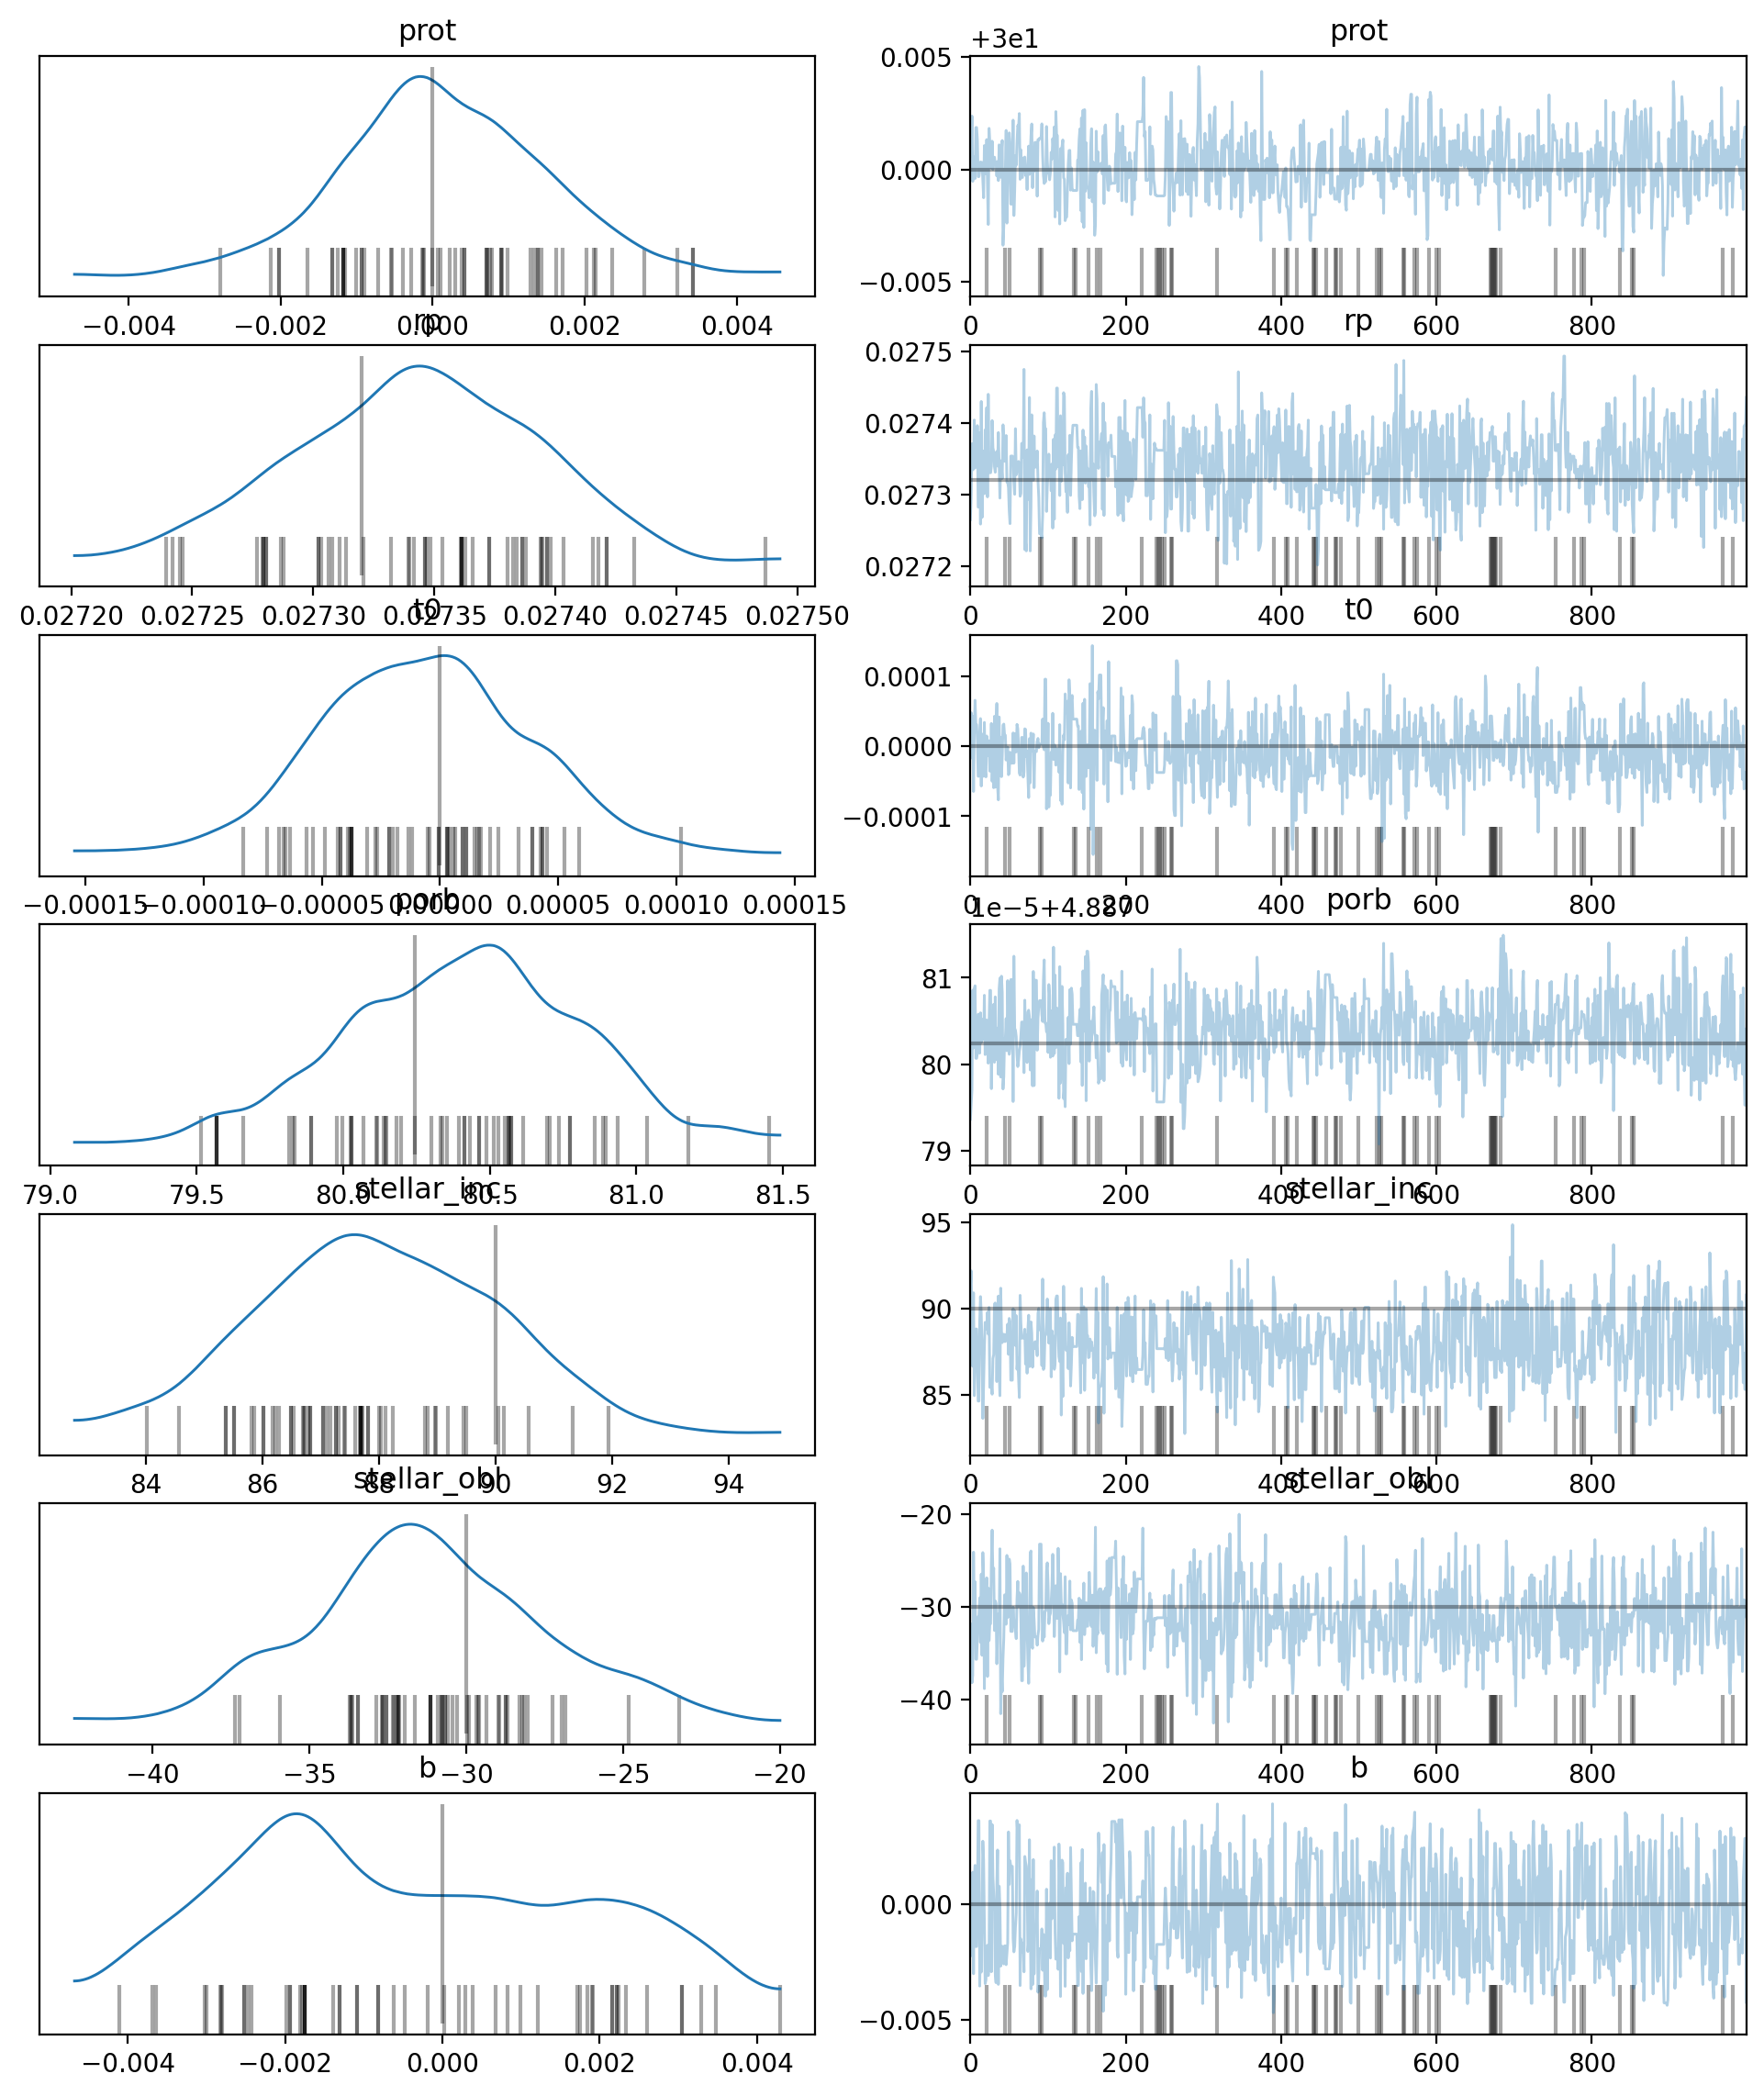

In [42]:
az.plot_trace(trace, var_names=['prot', 'rp', 't0', 'porb', 'stellar_inc', 'stellar_obl', 'b'],
              lines=[('prot', {}, pri.prot.eval()), 
                     ('rp', {}, sec.r.eval()),
                     ('t0', {}, 0),
                     ('porb', {}, sec.porb.eval()),
                     ('stellar_inc', {}, 90.0), # pri.map.inc.eval()),
                     ('stellar_obl', {}, -30),
                     ('b', {}, 0)])

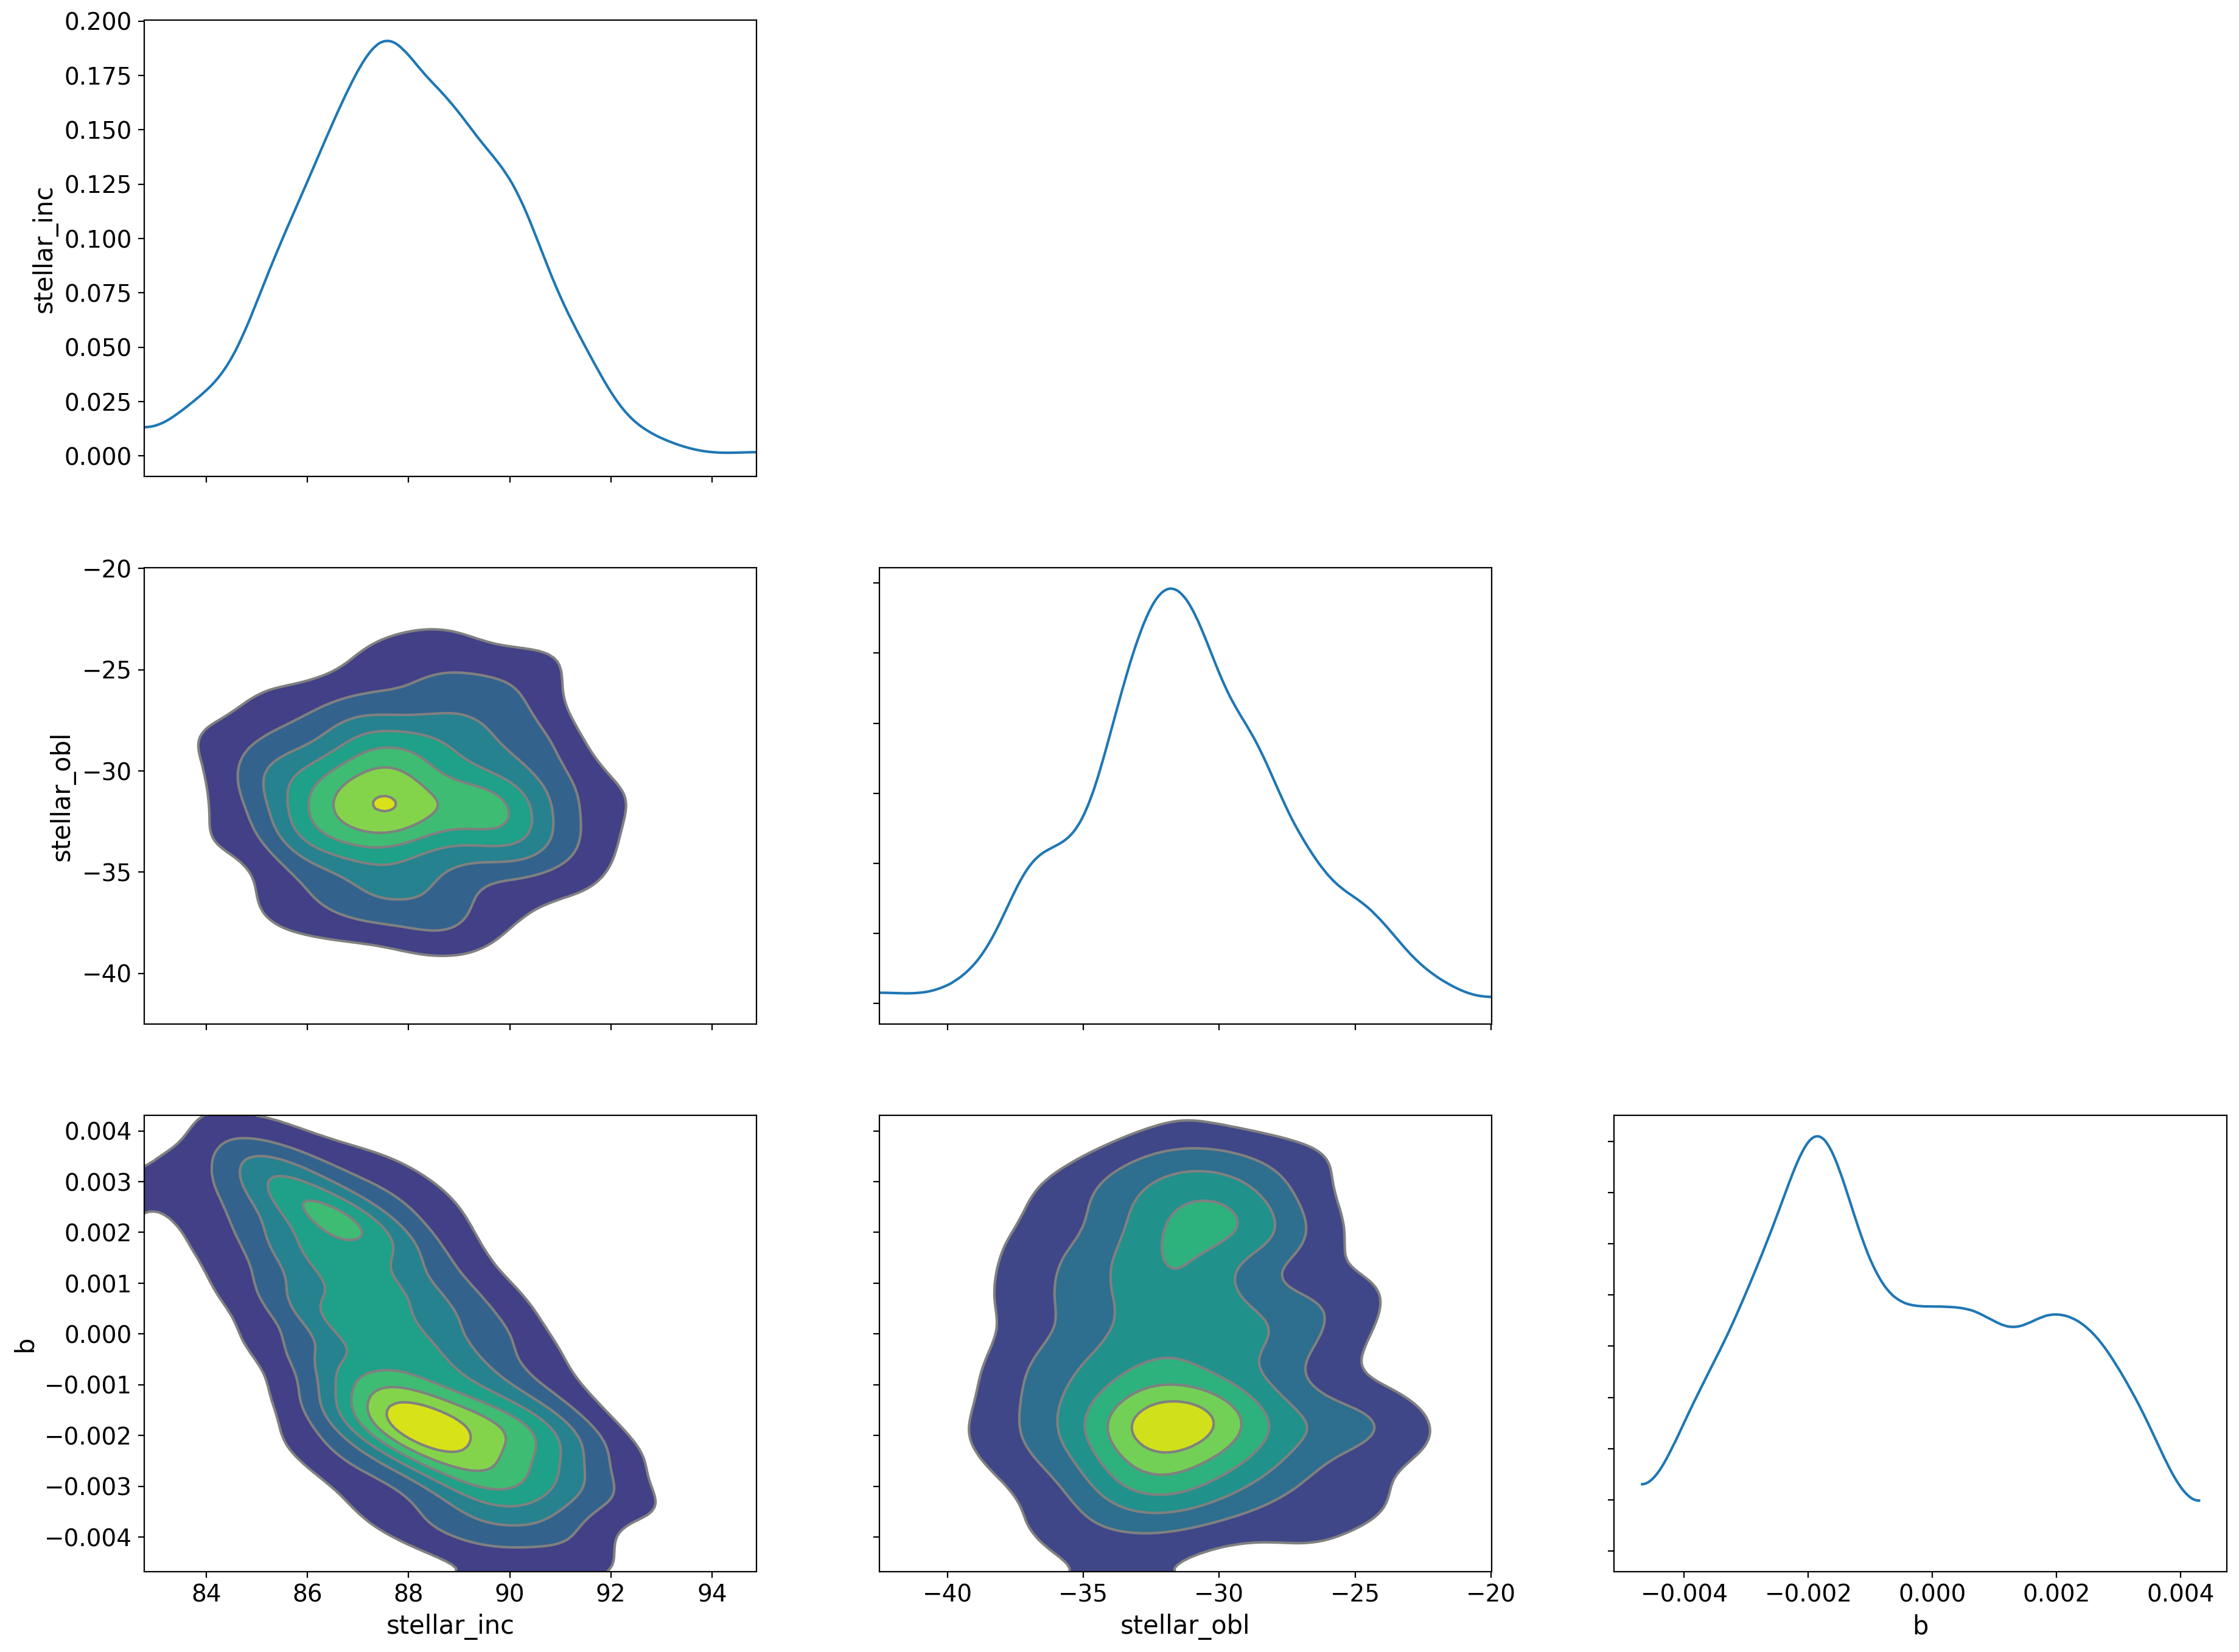

In [43]:
grid = az.plot_pair(trace, var_names=['stellar_inc', 'stellar_obl', 'b'], kind='kde', marginals=True)

array([[<Axes: >, None],
       [<Axes: xlabel='porb', ylabel='t0'>, <Axes: >]], dtype=object)

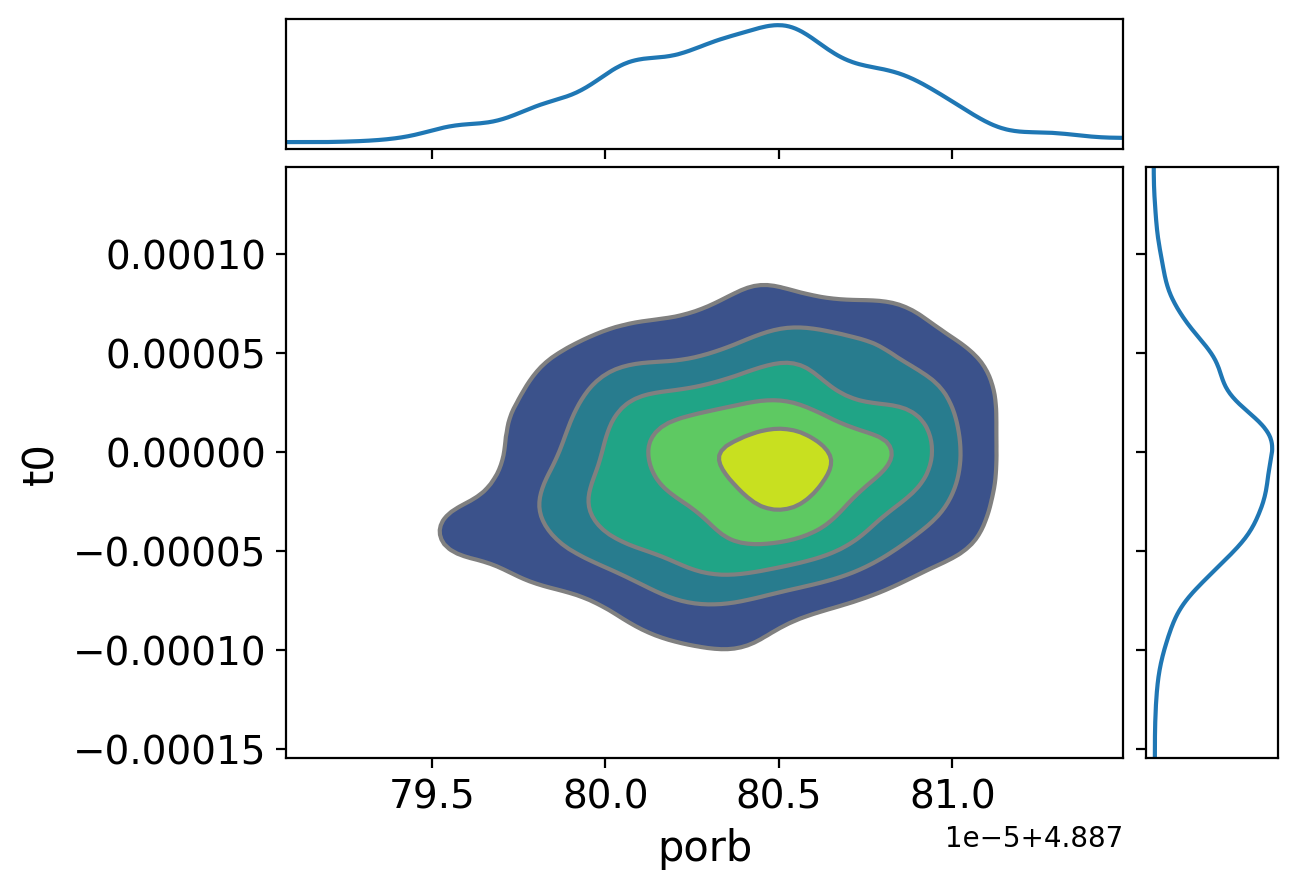

In [44]:
az.plot_pair(trace, var_names=['porb', 't0'], kind='kde', marginals=True)

Let's fill in all the maps:

In [55]:
p = trace.posterior.sel(chain=0, draw=0)

In [66]:
map_ylms = []
f = theano.function([model.prot, model.porb, model.stellar_inc, model.stellar_obl, model.b, model.t0, model.rp], ssp_model.sample_ylm_conditional(t, flux_obs, sigma_flux))

for c in trace.posterior.coords['chain']:
    for d in tqdm(trace.posterior.coords['draw']):
        p = trace.posterior.sel(chain=c, draw=d)
        map_ylms.append(f(p.prot, p.porb, p.stellar_inc, p.stellar_obl, p.b, p.t0, p.rp))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [67]:
map_ylms = np.array(map_ylms)
map_ylms = np.reshape(map_ylms, (1, -1, ssp.nlm))

Here is the true surface map

/Users/wfarr/miniconda3/envs/StarryStarryProcess/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


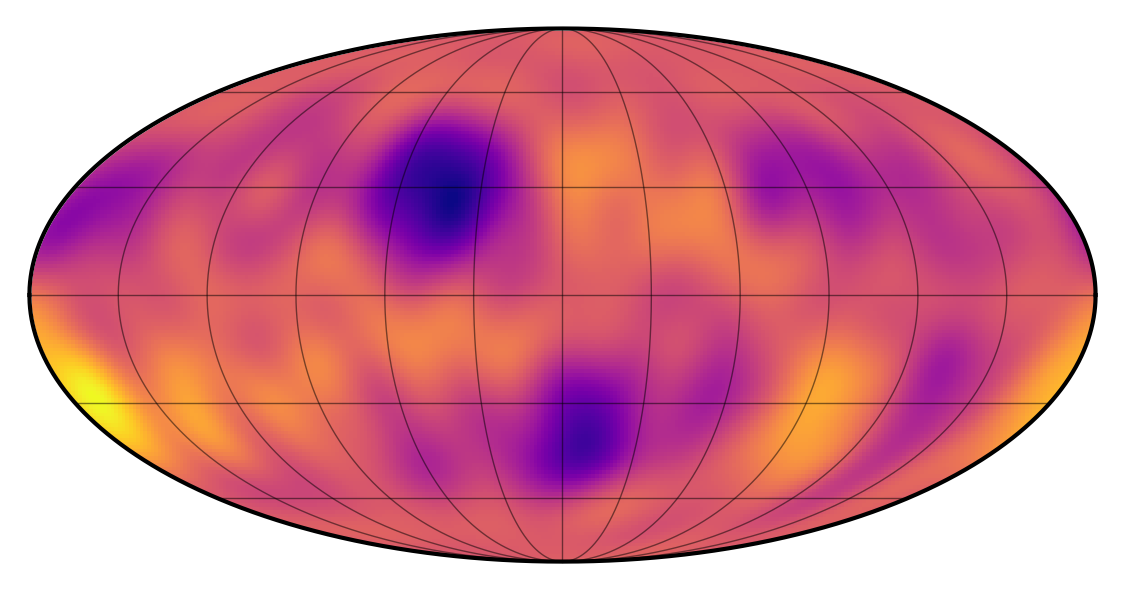

In [71]:
sp_model.visualize(y_true)

And here is the posterior mean surface map:

/Users/wfarr/miniconda3/envs/StarryStarryProcess/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


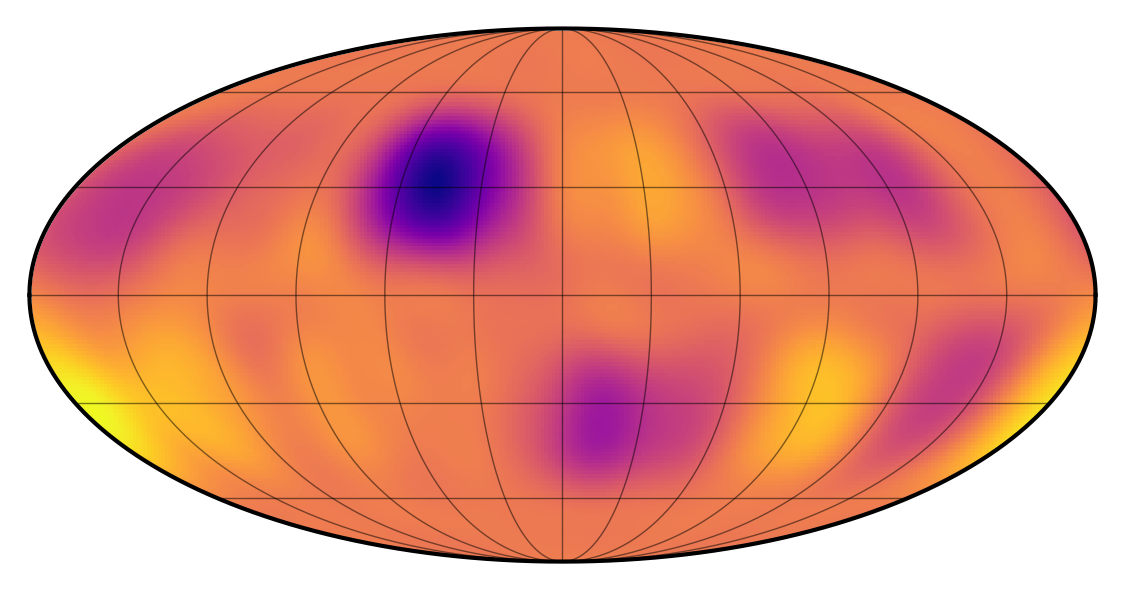

In [69]:
sp_model.visualize(np.mean(map_ylms, axis=(0,1)))

And some draws from the posterior:

/Users/wfarr/miniconda3/envs/StarryStarryProcess/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


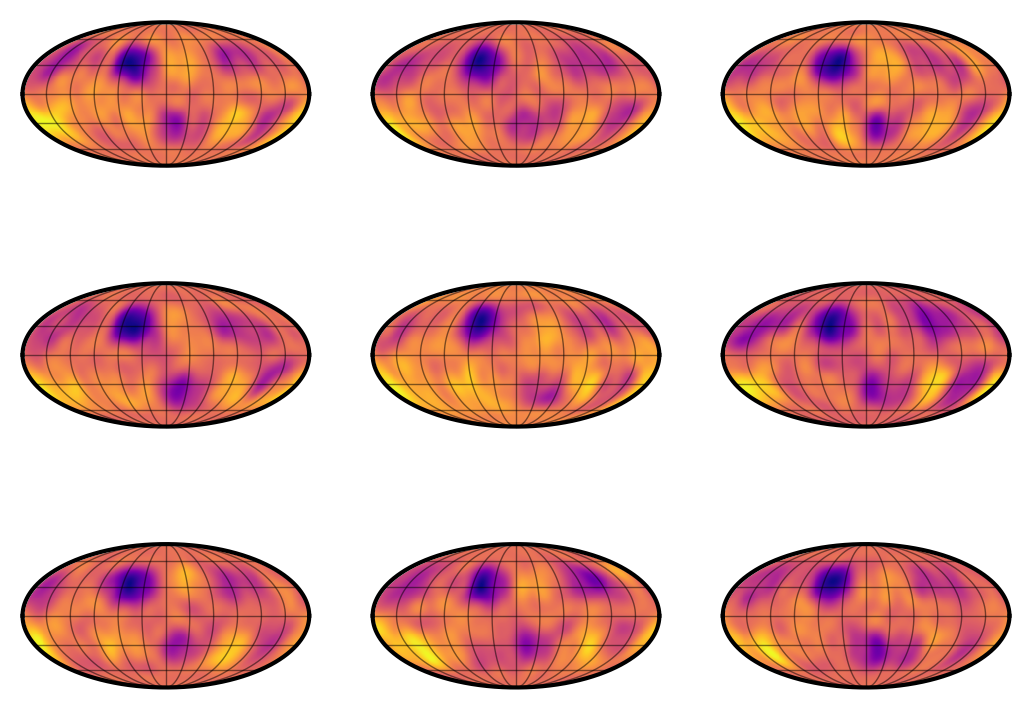

In [76]:
fig, axs = plt.subplots(3, 3)
for ax in axs.flatten():
    i = np.random.randint(map_ylms.shape[0])
    j = np.random.randint(map_ylms.shape[1])

    y = map_ylms[i,j,:]

    sp_model.visualize(y, ax=ax)


Save the trace:

In [77]:
az.to_netcdf(trace, '/Users/wfarr/Downloads/SSP-trace.nc')

'/Users/wfarr/Downloads/SSP-trace.nc'